# Introduction to Data Science

Authors: Lior Tondovski, Ilan Vasilevski, Maya Vilenko

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.utils import resample
# import smote
from imblearn.over_sampling import SMOTE
#inport stadard scaler
from sklearn.preprocessing import StandardScaler
#import holidays
import holidays
#import progress apply
from tqdm import tqdm
tqdm.pandas()
#split the data into train and validation sets
from sklearn.model_selection import train_test_split

from utils import *
from config import *

In [2]:
#read the data
train_data = pd.read_csv(training_data_path)
test_data = pd.read_csv(test_data_path)

In [3]:
#check how many positive and negative samples are there
train_data.clicked.value_counts()

False    2348498
True      170558
Name: clicked, dtype: int64

In [4]:
#data shape
print(f'the shape of the train_data is {train_data.shape}')
print(f'the shape of the test_data is {test_data.shape}')
print(f'the ratio between the train and test data is {round(test_data.shape[0]/train_data.shape[0], 2)}')

the shape of the train_data is (2519056, 14)
the shape of the test_data is (629764, 13)
the ratio between the train and test data is 0.25


##### EDA

In [5]:
train_data.head(3)

,op_id,timestamp,state,user_isp,app_id,app_cat,banner_pos,manufacturer,device_model,device_version,device_height,device_width,resolution,clicked
0,448ed944-b0a3-4f8e-9662-fb1202e2777b,1569445326,New Jersey,Comcast Cable,6rm7ag7,games - simulation,top-right,Samsung,SM-G925V,6.0.1,792,1408,True,False
1,3c501ca8-f771-4926-acce-d532f979b8b5,1566517297,Illinois,Verizon Wireless,74193f6,games - card,right,NaN,NaN,7.0,2560,1440,True,False
2,db342130-0f34-4d43-a72c-3c1891eade24,1566375809,California,T-Mobile USA,6549c21,games - puzzle,top-left,NaN,NaN,7.0,1280,720,True,False


In [6]:
test_data.head(3)

,op_id,timestamp,state,user_isp,app_id,app_cat,banner_pos,manufacturer,device_model,device_version,device_height,device_width,resolution
0,63166542-e886-492f-8ff3-4d4f24c03363,1569363301,Minnesota,Savage Communications,59da3a2,games - board,bottom-right,Samsung,SM-S727VL,6.0.1,720,1280,True
1,411ef0c9-2bdc-48ea-ad87-1f257445efcf,1568625996,Wisconsin,Spectrum,pnomoth,games - puzzle,left,Samsung,SM-G920R4,7,1920,1080,True
2,36ad3f28-87dc-4843-963a-43908e120038,1570769732,Florida,Spectrum Business,3tsgr77,unknown,bottom-right,Motorola,Moto E4,7.1.1,720,1280,True


In [7]:
#check unique values in each column
train_data.nunique()

op_id             2519056
timestamp         1930791
state                  51
user_isp             3316
app_id              14315
app_cat                46
banner_pos              9
manufacturer          251
device_model         2256
device_version         16
device_height         297
device_width          238
resolution              1
clicked                 2
dtype: int64

it can be seen for example that resolution column has a single value so it doesnt add any information and we will remove it in the preprocess phase

In [8]:
#Data types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519056 entries, 0 to 2519055
Data columns (total 14 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   op_id           object
 1   timestamp       int64 
 2   state           object
 3   user_isp        object
 4   app_id          object
 5   app_cat         object
 6   banner_pos      object
 7   manufacturer    object
 8   device_model    object
 9   device_version  object
 10  device_height   int64 
 11  device_width    int64 
 12  resolution      bool  
 13  clicked         bool  
dtypes: bool(2), int64(3), object(9)
memory usage: 235.4+ MB


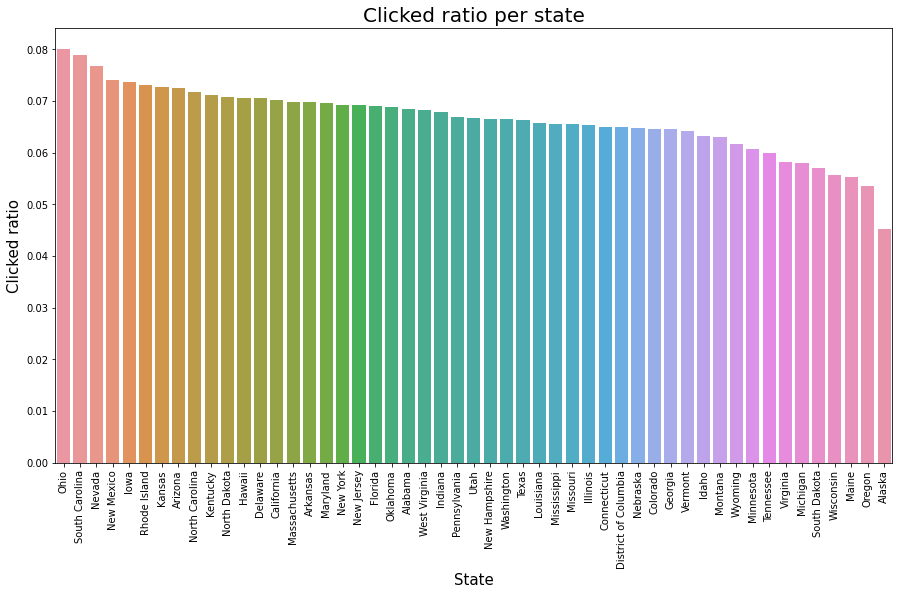

In [9]:
#plot bat chart of clicked ratio per state
#first we need to group the data by state and count the number of clicks
state_clicks = train_data.groupby('state')['clicked'].mean().reset_index()
state_clicks = state_clicks.sort_values(by='clicked', ascending=False)

#plot the data
plt.figure(figsize=(15, 8))
sns.barplot(x='state', y='clicked', data=state_clicks)
plt.title('Clicked ratio per state', fontsize=20)
plt.xlabel('State', fontsize=15)
plt.ylabel('Clicked ratio', fontsize=15)
#rotate the x labels
plt.xticks(rotation=90)
plt.show()


There is not much variation in the click ratio between the countries

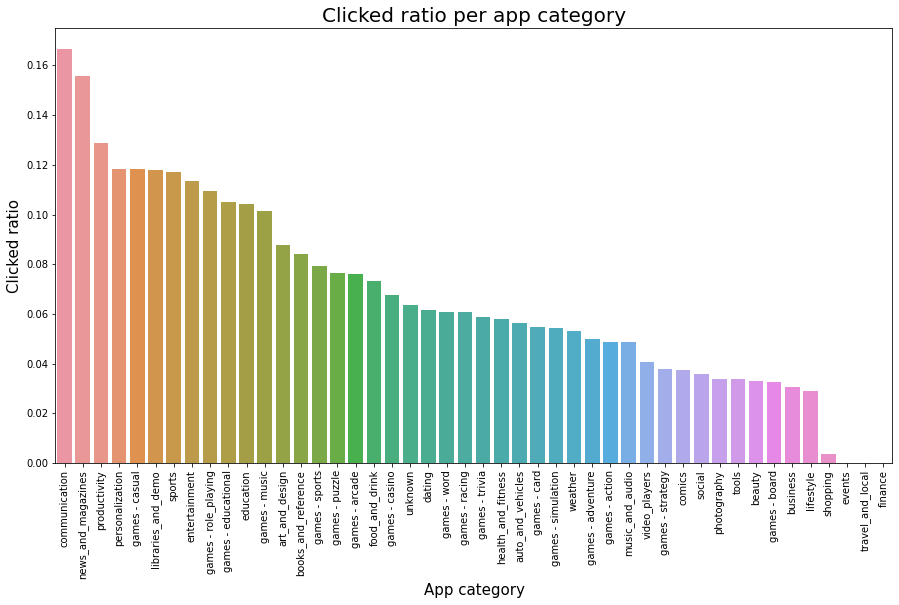

In [10]:
#plot click ratio per app category
#first we need to group the data by app category and count the number of clicks
app_clicks = train_data.groupby('app_cat')['clicked'].mean().reset_index()
app_clicks = app_clicks.sort_values(by='clicked', ascending=False)

#plot the data
plt.figure(figsize=(15, 8))
sns.barplot(x='app_cat', y='clicked', data=app_clicks)
plt.title('Clicked ratio per app category', fontsize=20)
plt.xlabel('App category', fontsize=15)
plt.ylabel('Clicked ratio', fontsize=15)
#rotate the x labels
plt.xticks(rotation=90)
plt.show()


Graph shows that click ratios are pretty varied between categories of applications

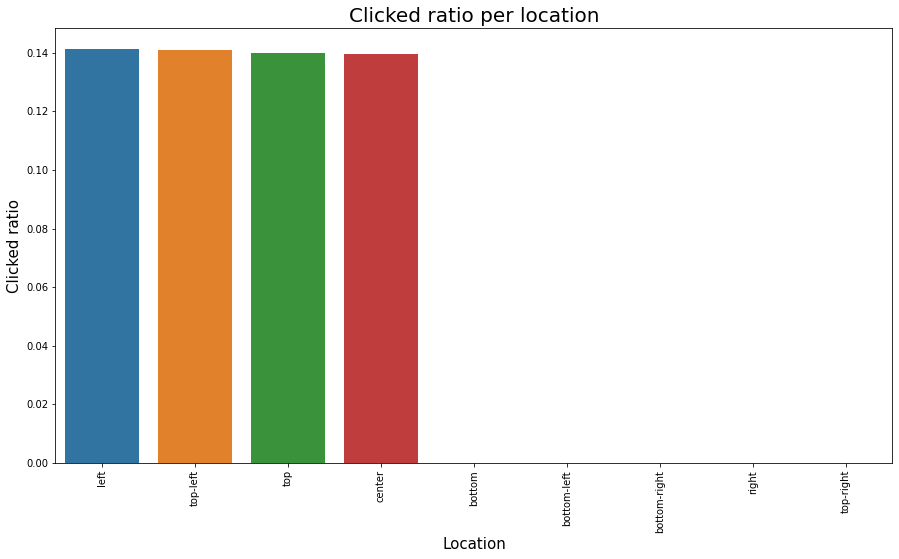

In [11]:
#plot click ratio per the location of the add
#first we need to group the data by location and count the number of clicks
location_clicks = train_data.groupby('banner_pos')['clicked'].mean().reset_index()
location_clicks = location_clicks.sort_values(by='clicked', ascending=False)

#plot the data
plt.figure(figsize=(15, 8))
sns.barplot(x='banner_pos', y='clicked', data=location_clicks)
plt.title('Clicked ratio per location', fontsize=20)
plt.xlabel('Location', fontsize=15)
plt.ylabel('Clicked ratio', fontsize=15)
#rotate the x labels
plt.xticks(rotation=90)
plt.show()


In [12]:
train_data['banner_pos'].value_counts()

top-left        304202
left            303553
center          303523
top             302920
bottom-left     261692
top-right       261076
right           261048
bottom-right    260598
bottom          260444
Name: banner_pos, dtype: int64

In [13]:
#change bottom categories to one category in the banner_pos category
train_data['banner_pos'] = train_data['banner_pos'].apply(lambda x: 'bottom' if x in ['bottom', 'bottom-left', 'bottom-right', 'right', 'top-right'] else x)
test_data['banner_pos'] = test_data['banner_pos'].apply(lambda x: 'bottom' if x in ['bottom', 'bottom-left', 'bottom-right', 'right', 'top-right'] else x)

According to this graph, adds on the bottom/right of the screen are less likely to be clicked!

##### Missing Values

In [14]:
train_data_missing_values = check_missing_values(train_data)
test_data_missing_values = check_missing_values(test_data)

In [15]:
#check the missing values in the train data
train_data_missing_values[train_data_missing_values['missing_values_percentage']>0]

,column,missing_values,missing_values_percentage
7,manufacturer,770942,0.306044
8,device_model,770846,0.306006
3,user_isp,32,0.000013


In [16]:
#check the missing values in the test data
test_data_missing_values[test_data_missing_values['missing_values_percentage']>0]

,column,missing_values,missing_values_percentage
7,manufacturer,193061,0.306561
8,device_model,193011,0.306481
3,user_isp,7,0.000011


##### Preprocess & Feature Extraction

In [17]:
#replace missing values with the category 'unknown'
#the reason that we replace the missing values with the category 'unknown' is because we want to keep the information that the value is missing
train_data = replace_missing_values(train_data)
test_data = replace_missing_values(test_data)

In [18]:
# leave only the top k manufacturers
k = 14
top_mfcrs = train_data['manufacturer'].value_counts().head(k+1).index
train_data['manufacturer'] = train_data['manufacturer'].apply(lambda x: x if x in top_mfcrs else 'other')
test_data['manufacturer'] = test_data['manufacturer'].apply(lambda x: x if x in top_mfcrs else 'other')

In [19]:
# one hot encoding 
# we will use one hot encoding for the following columns: state, manufacturer, app_cat, banner_pos, device_version
get_dummis = ['state','manufacturer', 'app_cat', 'banner_pos', 'device_version']
train_data = pd.get_dummies(train_data, columns=get_dummis, prefix=get_dummis)
test_data = pd.get_dummies(test_data, columns=get_dummis, prefix=get_dummis)

# columns to drop: 
drop_cols = [ 
            'op_id',        #op_id colums assigns unique id to each row and it is not useful for our model
            'app_id',       #app_id column has a high cardinality
            'resolution'    #resolution column has a single value
            ]
# drop columns
train_data.drop(columns=drop_cols, inplace=True)
test_data.drop(columns=drop_cols, inplace=True)

#change the target variable to binary feature
train_data['clicked'] = train_data['clicked'].apply(lambda x: 1 if x == True else 0)

In [20]:
#There are some model versions that doesnt appear in the test data and vice versa
train_cols = set([x for x in  train_data.columns if x!='clicked'])
test_cols = set([x for x in  test_data.columns])
bad_cols = train_cols.union(test_cols) - train_cols.intersection(test_cols)

train_data= train_data.loc[:,[x for x in train_data.columns if x not in bad_cols]]
test_data= test_data.loc[:,[x for x in test_data.columns if x not in bad_cols]]

In [21]:
#Extract new features from the categorical features and drop the original features
#The features are the ratio of the number of clicks for each category in each feature
try:
    train_data = pd.read_pickle('processed_files/train_data_stage_1.pkl')
    test_data = pd.read_pickle('processed_files/test_data_stage_1.pkl')
except:
    categorical_columns = ['user_isp', 'device_model']
    train_data, test_data = check_the_ratio_of_clicked_from_feature(train_data, test_data, categorical_columns)
    #save the processed data
    train_data.to_pickle('processed_files/train_data_stage_1.pkl')
    test_data.to_pickle('processed_files/test_data_stage_1.pkl')

100%|██████████| 2257/2257 [04:31<00:00,  8.33it/s]


In [22]:
#change timestamp number to datetime
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'], unit='s')
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'], unit='s')
#change timestamp to date and check if it is a us holiday
train_data['date'] = train_data['timestamp'].dt.date
test_data['date'] = test_data['timestamp'].dt.date
#extract hour, day, month and year from the timestamp
train_data['hour'] = train_data['timestamp'].dt.hour
train_data['day'] = train_data['timestamp'].dt.day
train_data['month'] = train_data['timestamp'].dt.month
train_data['year'] = train_data['timestamp'].dt.year

test_data['hour'] = test_data['timestamp'].dt.hour
test_data['day'] = test_data['timestamp'].dt.day
test_data['month'] = test_data['timestamp'].dt.month
test_data['year'] = test_data['timestamp'].dt.year
#drop timestamp column
train_data.drop(columns=['timestamp'], inplace=True)
test_data.drop(columns=['timestamp'], inplace=True)
train_data.drop(columns=['date'], inplace=True)
test_data.drop(columns=['date'], inplace=True)

##### Target Varible Distributin - Check if the Data is Balanced or Not?

In [23]:
#check if the data is balanced
print(f'number of negative samples {train_data[train_data.clicked == 0].shape[0]}')
print(f'number of positive samples {train_data[train_data.clicked == 1].shape[0]}')
print(f'The ratio of negative samples to positive samples is {(train_data[train_data.clicked == 0].shape[0] / train_data.shape[0])*100:.2f}%')
print(f'The ratio of positive samples to negative samples is {(train_data[train_data.clicked == 1].shape[0] / train_data.shape[0])*100:.2f}%')

number of negative samples 2348498
number of positive samples 170558
The ratio of negative samples to positive samples is 93.23%
The ratio of positive samples to negative samples is 6.77%


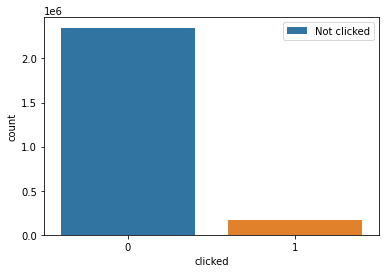

In [24]:
#plot the distribution of the target variable
sns.countplot(x='clicked', data=train_data)
plt.legend(['Not clicked', 'Clicked'])

This dataset is completely unbalanced, as can be seen!

##### correlation Analysis

In [25]:
#Because the there are many features, we will plot only the features with the highest correlation with the target variable
#find the correlation between the features and the target variable
#Note: it takes a long time to run this code because there are many features in the data and the correlation is calculated for each feature
correlation = train_data.corr()
correlation = correlation.sort_values(by='clicked', ascending=False)
#most correlated features with the target variable
plt.figure(figsize=(15, 8))
sns.heatmap(correlation.head(10)[list(correlation.head(10).index.values)], annot=True, cmap='coolwarm')
plt.title('Correlation matrix of the features with the highest correlation with the target variable', fontsize=20)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.show()

It can be seen that device mode ratio clicked and the LG manifucturer are correlated.

It can be seen that the banner location has the highest correlation with the label.

##### Standartization Before SMOTE

In [27]:
#if column contain two values change its type to boolean
bools = []
for col in train_data.columns:
    if train_data[col].nunique() == 2:
        bools.append(col)

#get all bool columns
columns_to_standardize = [x for x in train_data.columns if not x in bools]

#standardize the numerical features
#The reason for standardizing the numerical features is that the numerical features have different scales and Smote algorithm is based on the euclidean distance (knn algorithm)#standardize the train data with standard scaler
scaler = StandardScaler()
train_data[columns_to_standardize] = scaler.fit_transform(train_data[columns_to_standardize])
#standardize the test data with standard scaler
test_data[columns_to_standardize] = scaler.transform(test_data[columns_to_standardize])

In [28]:
#Split the train data to train and validation data in order to check the performance of the model on the validation data
train_data, validation_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['clicked'])

In [29]:
#save the train, validation and test data
validation_data.to_pickle('processed_files/validation_data.pkl')
test_data.to_pickle('processed_files/test_data.pkl')

##### Undersampling

In [30]:
#The reason that we do undersampling is that the data is imbalanced and there are a lot of negative samples and few positive samples and the model will be biased towards
# the negative sample so we will undersample the negative samples and oversample the positive samples using SMOTE algorithm

# Separate majority and minority classes
train_data_majority = train_data[train_data.clicked==0]
train_data_minority = train_data[train_data.clicked==1]

# Downsample majority class
df_majority_downsampled = resample(train_data_majority,
                                    replace=False,    # sample without replacement
                                    n_samples=train_data_minority.shape[0]*2,  # The majority class will be downsampled to the size of the minority * 2
                                    random_state=12) # reproducible results

# Combine minority class with downsampled majority class
train_data_under_sampled = pd.concat([df_majority_downsampled, train_data_minority])
# Display new class counts
print(train_data_under_sampled.clicked.value_counts())


0    272892
1    136446
Name: clicked, dtype: int64


In [31]:
#save the train data after undersampling to a pickle file
train_data_under_sampled.to_pickle('processed_files/train_data_undersampled.pkl')

##### SMOTE

In [32]:
#apply smote on train_data_under_sampled
#we use sampling_strategy=1.0 because we want to oversample the positive samples to the size of the negative samples
sm = SMOTE(random_state=12, sampling_strategy=1.0)
X_train_sm, y_train_sm = sm.fit_resample(train_data_under_sampled.drop(columns=['clicked']), train_data_under_sampled.clicked)
#convert the data to pandas dataframe
X_train_sm = pd.DataFrame(X_train_sm, columns=train_data_under_sampled.drop(columns=['clicked']).columns)
y_train_sm = pd.DataFrame(y_train_sm, columns=['clicked'])

#combine the data
train_data_under_sampled_sm = pd.concat([X_train_sm, y_train_sm], axis=1)

#distribution of the target variable
train_data_under_sampled_sm['clicked'].value_counts()

0    272892
1    272892
Name: clicked, dtype: int64

In [33]:
#save the train_data_under_sampled_sm to pickle file
train_data_under_sampled_sm.to_pickle('processed_files/train_data_undersampled_sm.pkl')
